In [1]:
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
from scipy import stats
from numpy import matlib
import matplotlib.path as mpath
import matplotlib.ticker as mticker 
from matplotlib import mlab
from scipy import integrate

# Read the daily O3 on pressure levels

In [2]:
%cd -b ii005
ref1 = xr.open_dataset('FOCI1.13-II005_echam6_tracer_1958-2013_O3_pl_daily.nc', decode_times=True)
%cd -b ii006
ref2 = xr.open_dataset('FOCI1.14-II006_echam6_tracer_1958-2013_O3_daily_pl.nc', decode_times=True)
%cd -b ii007
ref3 = xr.open_dataset('FOCI1.14-II007_echam6_tracer_1958-2013_O3_pl_daily.nc', decode_times=True)
%cd -b ii008
ods1 = xr.open_dataset('FOCI1.14-II008_echam6_tracer_1958-2013_O3_pl_daily.nc', decode_times=True)
%cd -b sw112
ods2 = xr.open_dataset('FOCI1.14-SW112_echam6_tracer_1958-2013_O3_pl_daily.nc', decode_times=True)
%cd -b sw114
ods3 = xr.open_dataset('FOCI1.14-SW114_echam6_tracer_1958-2013_O3_pl_daily.nc', decode_times=True)
%cd -b ii009
ghg1 = xr.open_dataset('FOCI1.14-II009_echam6_tracer_1958-2013_O3_pl_daily.nc', decode_times=True)
%cd -b sw113
ghg2 = xr.open_dataset('FOCI1.14-SW113_echam6_tracer_1958-2013_O3_pl_daily.nc', decode_times=True)
%cd -b sw115
ghg3 = xr.open_dataset('FOCI1.14-SW115_echam6_tracer_1958-2013_O3_pl_daily.nc', decode_times=True)

(bookmark:ii005) -> /gxfs_work1/geomar/smomw418/models/foci1.13/experiments/FOCI1.13-II005/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci1.13/experiments/FOCI1.13-II005/outdata/echam6
(bookmark:ii006) -> /gxfs_work1/geomar/smomw418/models/foci1.14/experiments/FOCI1.14-II006/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci1.14/experiments/FOCI1.14-II006/outdata/echam6
(bookmark:ii007) -> /gxfs_work1/geomar/smomw418/models/foci1.14/experiments/FOCI1.14-II007/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci1.14/experiments/FOCI1.14-II007/outdata/echam6
(bookmark:ii008) -> /gxfs_work1/geomar/smomw418/models/foci1.14/experiments/FOCI1.14-II008/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci1.14/experiments/FOCI1.14-II008/outdata/echam6
(bookmark:sw112) -> /sfs/fs1/work-geomar/smomw418/models/foci1.14/experiments/FOCI1.14-SW112/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci1.14/experiments/FOCI1.14-SW112/outdata/

In [3]:
ref1

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 96, lon: 192, plev: 26, time: 20454)
Coordinates:
  * time       (time) datetime64[ns] 1958-01-01T09:00:00 ... 2013-12-31T09:00:00
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat        (lat) float64 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * plev       (plev) float64 1e+05 9.25e+04 8.5e+04 7.75e+04 ... 50.0 20.0 10.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    O3         (time, plev, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.7rc1 (http://mpimet.mpg....
    history:      Tue Feb 04 16:26:24 2020: cdo daymean FOCI1.13-II005_echam6...
    institution:  Max-Planck-Institute for Meteorology
    Conventions:  CF-1.6
    frequency:    day
    CDO:          Climate Data Operators version 1.9.7rc1 (http://mpimet.mpg....

## Define function to compute volume mixing ratio (ppmv) 

In [4]:
def ii_ozone_vmr(ozone):
    # Input: ozone -> O3 mass mixing ratio in kg/kg

    # Convert from kg/kg to microg/g (multiply by 10^6)
    m = ozone*1e6
    # Convert the mass mixing ratio to volume mixing ratio in ppmv
    vmr = m*(28.9644/47.9982) # approx 0.603
    
    return vmr

## Time vs pressure plots of O3 volume mixing ratio differences over the polar cap (70S-90S)

In [5]:
def sel_days(data):
    def is_day(day, d, month, m):
        return (day==d) & (month==m) # returns an array with true where the day of the year is d and false elswhere
    
    # 1st of Janary
    data_out = data.sel(time=is_day(data['time.day'],1, data['time.month'],1)).groupby('time.year').mean(dim='time')

    # January
    for d in range(2,32):
        data_day = data.sel(time=is_day(data['time.day'],d, data['time.month'],1)).groupby('time.year').mean(dim='time')
        data_out = xr.concat((data_out, data_day), dim='day')
    # February
    for d in range(1,29):
        data_day = data.sel(time=is_day(data['time.day'],d, data['time.month'],2)).groupby('time.year').mean(dim='time')
        data_out = xr.concat((data_out, data_day), dim='day')
    # March
    for d in range(1,32):
        data_day = data.sel(time=is_day(data['time.day'],d, data['time.month'],3)).groupby('time.year').mean(dim='time')
        data_out = xr.concat((data_out, data_day), dim='day')
    # April
    for d in range(1,31):
        data_day = data.sel(time=is_day(data['time.day'],d, data['time.month'],4)).groupby('time.year').mean(dim='time')
        data_out = xr.concat((data_out, data_day), dim='day')
    # May
    for d in range(1,32):
        data_day = data.sel(time=is_day(data['time.day'],d, data['time.month'],5)).groupby('time.year').mean(dim='time')
        data_out = xr.concat((data_out, data_day), dim='day')
    # June
    for d in range(1,31):
        data_day = data.sel(time=is_day(data['time.day'],d, data['time.month'],6)).groupby('time.year').mean(dim='time')
        data_out = xr.concat((data_out, data_day), dim='day')
    # July
    for d in range(1,32):
        data_day = data.sel(time=is_day(data['time.day'],d, data['time.month'],7)).groupby('time.year').mean(dim='time')
        data_out = xr.concat((data_out, data_day), dim='day')
    # August
    for d in range(1,32):
        data_day = data.sel(time=is_day(data['time.day'],d, data['time.month'],8)).groupby('time.year').mean(dim='time')
        data_out = xr.concat((data_out, data_day), dim='day')
    # September
    for d in range(1,31):
        data_day = data.sel(time=is_day(data['time.day'],d, data['time.month'],9)).groupby('time.year').mean(dim='time')
        data_out = xr.concat((data_out, data_day), dim='day')
    # October
    for d in range(1,32):
        data_day = data.sel(time=is_day(data['time.day'],d, data['time.month'],10)).groupby('time.year').mean(dim='time')
        data_out = xr.concat((data_out, data_day), dim='day')
    # November
    for d in range(1,31):
        data_day = data.sel(time=is_day(data['time.day'],d, data['time.month'],11)).groupby('time.year').mean(dim='time')
        data_out = xr.concat((data_out, data_day), dim='day')
    # December
    for d in range(1,32):
        data_day = data.sel(time=is_day(data['time.day'],d, data['time.month'],12)).groupby('time.year').mean(dim='time')
        data_out = xr.concat((data_out, data_day), dim='day')
    
    day = np.arange(1,366)
    data_out = data_out.assign_coords(day=day)
    
    return data_out

In [6]:
def diff_day_plev_O3(data1, data2, data3, data01, data02, data03):
    
    # Compute area means for 70S-90S 
    zm1 = data1.sel(lat=slice(-70,-90)).mean(dim='lat').mean(dim='lon').squeeze()
    zm2 = data2.sel(lat=slice(-70,-90)).mean(dim='lat').mean(dim='lon').squeeze()
    zm3 = data3.sel(lat=slice(-70,-90)).mean(dim='lat').mean(dim='lon').squeeze()
    
    zm01 = data01.sel(lat=slice(-70,-90)).mean(dim='lat').mean(dim='lon').squeeze()
    zm02 = data02.sel(lat=slice(-70,-90)).mean(dim='lat').mean(dim='lon').squeeze()
    zm03 = data03.sel(lat=slice(-70,-90)).mean(dim='lat').mean(dim='lon').squeeze()
    print('Area means done')
    
    # Compute volume mixing ratio
    zm1 = ii_ozone_vmr(zm1)
    zm2 = ii_ozone_vmr(zm2)
    zm3 = ii_ozone_vmr(zm3)
    zm01 = ii_ozone_vmr(zm01)
    zm02 = ii_ozone_vmr(zm02)
    zm03 = ii_ozone_vmr(zm03)
    print('O3 vmr calculation done')
    
    # Select days
    daily1 = sel_days(zm1)
    daily2 = sel_days(zm2)
    daily3 = sel_days(zm3)
    daily01 = sel_days(zm01)
    daily02 = sel_days(zm02)
    daily03 = sel_days(zm03)
    print('Daily selection done')
    
    # Compute ensemble means
    ens_mean1 = xr.concat((daily1, daily2, daily3), dim='exp').mean(dim='exp')
    ens_mean2 = xr.concat((daily01, daily02, daily03), dim='exp').mean(dim='exp')
    print('Ensemble means done')
    
    # Compute the variance over the stacked ensemble members for each calendar day
    stack1 = xr.concat((daily1, daily2, daily3), dim='year') # stack the ensemble members over dimension time
    stack2 = xr.concat((daily01, daily02, daily03), dim='year') # stack the ensemble members over dimension time
    
    var1 = ((stack1 - stack1.mean(dim='year'))**2).sum(dim='year') # compute the variance
    var2 = ((stack2 - stack2.mean(dim='year'))**2).sum(dim='year') # compute the variance
    
    # Define function for t-test (95%) 
    
    def ii_t_test(data1, data2, var1, var2):
        #------------------ t-test for the significance of the difference of means-----------------------------------
        # Following Zwiers and von Storch (1995) and von Storhc and Zwiers Statistical Analysis in Climate Reasearch book.
        # The test is appropriete when the sum of the effective sample sizes of the two samples is grater than 30 (assuming equal varience).
        # Assumptions: 
        #     - the process from which "observations" are sampled is a Gaussian red noise process (AR(1))
        #     - both samples for which the difference of mean is tested come from red noise processes with equal variance and equal lag-1 autocorrelation
        # Input : data1, data2 -> the two 3D arrays for which the difference in means and its significance is calculated
        # Output: mean1., mean2 -> 2D arrays of time means corresponfing to data1, and data2, respectively
        #         diff -> the difference of means (2D array)
        #         signif -> 2D array with 1 where diff is significant at the 95% level and 0 elsewhere
        #         t -> the test statistic (difference divided by its standard error); (2D array)
        #         cv -> the critical value for the respective DOF and signif level (95%, two-sided test); (2D array)
        #         df -> the correspondig degress of freedom, given by the sum of the effective sample sizes -2; (2D array)
        # Author: Ioana Ivanciu on 28.03.2019

        import scipy.stats as st
        
        # Compute the pooled sample variance (Zwiers and von Storch 1995 eq. 13/ von Storch and Zwiers eq. 6.17)
        mean1 = data1.mean(dim='year')
        mean2 = data2.mean(dim='year')
        var = (var1 + var2) / ( len(data1.year)*3+len(data2.year)*3-2 )
    
        # Degrees of freedom for the t-test
        df = len(data1.year)*3+len(data2.year)*3-2  # von Storch and Zwiers book section 6 pg. 121
    
        # Compute the test statistic (von Storch and Zwiers book section 6 pg. 121 eq. 6.23; this differes from 
        # Zwiers and von Storch 1995 eq. 12 as the square root is placed elsewhere 
        diff = mean1 - mean2
        t = diff / ( np.sqrt(var) * np.sqrt(1/(len(data1.year)*3) + 1/(len(data2.year)*3)) )
    
        # Compute the critical value for a two-sided t-test with df
        # Use scipy.stats.t.pff -> gives the point at which a given percentile occurs for the t-distribution with df
        cv = st.t.ppf(0.975,df) # 0.975 because we want a two-sided test
    
        # Construct array with 1 where the difference is significant and 0 elsewhere
        signif = np.zeros(t.shape)
        signif[(xr.ufuncs.fabs(t)>cv).values] = 1 # take absolute value of t to include negative values
    
        return mean1, mean2, diff, signif, t, cv, df
    
    # Compute means, the difference between means and the significance
    mean1, mean2, diff, _, t, cv, _ = ii_t_test(ens_mean1, ens_mean2, var1, var2)
    
    diff_sign = xr.where(xr.ufuncs.fabs(t)>cv, diff, np.nan)
    
    return mean1, mean2, diff, diff_sign

In [7]:
a='1978-01-01'

In [8]:
ref_mean, noODS_mean, ods, ods_sign = diff_day_plev_O3(ref1.O3.sel(time=slice(a, '2002-12-31')), \
                                                       ref2.O3.sel(time=slice(a, '2002-12-31')), \
                                                       ref3.O3.sel(time=slice(a, '2002-12-31')), \
                                                       ods1.O3.sel(time=slice(a, '2002-12-31')), \
                                                       ods2.O3.sel(time=slice(a, '2002-12-31')), \
                                                       ods3.O3.sel(time=slice(a, '2002-12-31')))

Area means done
O3 vmr calculation done
Daily selection done
Ensemble means done


In [9]:
ref_mean, noGHG_mean, ghg, ghg_sign = diff_day_plev_O3(ref1.O3.sel(time=slice(a, '2002-12-31')), \
                                                       ref2.O3.sel(time=slice(a, '2002-12-31')), \
                                                       ref3.O3.sel(time=slice(a, '2002-12-31')), \
                                                       ghg1.O3.sel(time=slice(a, '2002-12-31')), \
                                                       ghg2.O3.sel(time=slice(a, '2002-12-31')), \
                                                       ghg3.O3.sel(time=slice(a, '2002-12-31')))

Area means done
O3 vmr calculation done
Daily selection done
Ensemble means done


## Read the zonal mean daily SW heating rates

In [10]:
%cd -b ii005
ref1_sw = xr.open_dataset('FOCI1.13-II005_echam6_tdiag_1958-2013_dtdt_rheat_sw_pl_daily_zm.nc', decode_times=True)
%cd -b ii006
ref2_sw = xr.open_dataset('FOCI1.14-II006_echam6_tdiag_1958-2013_dtdt_rheat_sw_pl_daily_zm.nc', decode_times=True)
%cd -b ii007
ref3_sw = xr.open_dataset('FOCI1.14-II007_echam6_tdiag_1958-2013_dtdt_rheat_sw_pl_daily_zm.nc', decode_times=True)

(bookmark:ii005) -> /gxfs_work1/geomar/smomw418/models/foci1.13/experiments/FOCI1.13-II005/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci1.13/experiments/FOCI1.13-II005/outdata/echam6
(bookmark:ii006) -> /gxfs_work1/geomar/smomw418/models/foci1.14/experiments/FOCI1.14-II006/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci1.14/experiments/FOCI1.14-II006/outdata/echam6
(bookmark:ii007) -> /gxfs_work1/geomar/smomw418/models/foci1.14/experiments/FOCI1.14-II007/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci1.14/experiments/FOCI1.14-II007/outdata/echam6


In [11]:
%cd -b ii008
noODS1_sw = xr.open_dataset('FOCI1.14-II008_echam6_tdiag_1958-2013_dtdt_rheat_sw_pl_daily_zm.nc', decode_times=True)
%cd -b sw112
noODS2_sw = xr.open_dataset('FOCI1.14-SW112_echam6_tdiag_1958-2013_dtdt_rheat_sw_pl_daily_zm.nc', decode_times=True)
%cd -b sw114
noODS3_sw = xr.open_dataset('FOCI1.14-SW114_echam6_tdiag_1958-2013_dtdt_rheat_sw_pl_daily_zm.nc', decode_times=True)

(bookmark:ii008) -> /gxfs_work1/geomar/smomw418/models/foci1.14/experiments/FOCI1.14-II008/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci1.14/experiments/FOCI1.14-II008/outdata/echam6
(bookmark:sw112) -> /sfs/fs1/work-geomar/smomw418/models/foci1.14/experiments/FOCI1.14-SW112/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci1.14/experiments/FOCI1.14-SW112/outdata/echam6
(bookmark:sw114) -> /sfs/fs1/work-geomar/smomw418/models/foci1.14/experiments/FOCI1.14-SW114/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci1.14/experiments/FOCI1.14-SW114/outdata/echam6


In [12]:
%cd -b ii009
noGHG1_sw = xr.open_dataset('FOCI1.14-II009_echam6_tdiag_1958-2013_dtdt_rheat_sw_pl_daily_zm.nc', decode_times=True)
%cd -b sw113
noGHG2_sw = xr.open_dataset('FOCI1.14-SW113_echam6_tdiag_1958-2013_dtdt_rheat_sw_pl_daily_zm.nc', decode_times=True)
%cd -b sw115
noGHG3_sw = xr.open_dataset('FOCI1.14-SW115_echam6_tdiag_1958-2013_dtdt_rheat_sw_pl_daily_zm.nc', decode_times=True)

(bookmark:ii009) -> /gxfs_work1/geomar/smomw418/models/foci1.14/experiments/FOCI1.14-II009/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci1.14/experiments/FOCI1.14-II009/outdata/echam6
(bookmark:sw113) -> /sfs/fs1/work-geomar/smomw418/models/foci1.14/experiments/FOCI1.14-SW113/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci1.14/experiments/FOCI1.14-SW113/outdata/echam6
(bookmark:sw115) -> /sfs/fs1/work-geomar/smomw418/models/foci1.14/experiments/FOCI1.14-SW115/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci1.14/experiments/FOCI1.14-SW115/outdata/echam6


In [13]:
# Make sure all have the same lat
ref1_sw = ref1_sw.assign_coords(lat=ref1.lat)
ref2_sw = ref2_sw.assign_coords(lat=ref1.lat)
ref3_sw = ref3_sw.assign_coords(lat=ref1.lat)
noODS1_sw = noODS1_sw.assign_coords(lat=ref1.lat)
noODS2_sw = noODS2_sw.assign_coords(lat=ref1.lat)
noODS3_sw = noODS3_sw.assign_coords(lat=ref1.lat)
noGHG1_sw = noGHG1_sw.assign_coords(lat=ref1.lat)
noGHG2_sw = noGHG2_sw.assign_coords(lat=ref1.lat)
noGHG3_sw = noGHG3_sw.assign_coords(lat=ref1.lat)

In [14]:
def diff_day_plev(data1, data2, data3, data01, data02, data03):
    
    # Compute area means for 70S-90S 
    zm1 = data1.sel(lat=slice(-70,-90)).mean(dim='lat').squeeze()
    zm2 = data2.sel(lat=slice(-70,-90)).mean(dim='lat').squeeze()
    zm3 = data3.sel(lat=slice(-70,-90)).mean(dim='lat').squeeze()
    
    zm01 = data01.sel(lat=slice(-70,-90)).mean(dim='lat').squeeze()
    zm02 = data02.sel(lat=slice(-70,-90)).mean(dim='lat').squeeze()
    zm03 = data03.sel(lat=slice(-70,-90)).mean(dim='lat').squeeze()
    print('Area means done')
    
    # Select days
    daily1 = sel_days(zm1)
    daily2 = sel_days(zm2)
    daily3 = sel_days(zm3)
    daily01 = sel_days(zm01)
    daily02 = sel_days(zm02)
    daily03 = sel_days(zm03)
    print('Daily selection done')
    
    # Compute ensemble means
    ens_mean1 = xr.concat((daily1, daily2, daily3), dim='exp').mean(dim='exp')
    ens_mean2 = xr.concat((daily01, daily02, daily03), dim='exp').mean(dim='exp')
    print('Ensemble means done')
    
    # Compute the variance over the stacked ensemble members for each calendar day
    stack1 = xr.concat((daily1, daily2, daily3), dim='year') # stack the ensemble members over dimension time
    stack2 = xr.concat((daily01, daily02, daily03), dim='year') # stack the ensemble members over dimension time
    
    var1 = ((stack1 - stack1.mean(dim='year'))**2).sum(dim='year') # compute the variance
    var2 = ((stack2 - stack2.mean(dim='year'))**2).sum(dim='year') # compute the variance
    
    # Define function for t-test (95%) 
    
    def ii_t_test(data1, data2, var1, var2):
        #------------------ t-test for the significance of the difference of means-----------------------------------
        # Following Zwiers and von Storch (1995) and von Storhc and Zwiers Statistical Analysis in Climate Reasearch book.
        # The test is appropriete when the sum of the effective sample sizes of the two samples is grater than 30 (assuming equal varience).
        # Assumptions: 
        #     - the process from which "observations" are sampled is a Gaussian red noise process (AR(1))
        #     - both samples for which the difference of mean is tested come from red noise processes with equal variance and equal lag-1 autocorrelation
        # Input : data1, data2 -> the two 3D arrays for which the difference in means and its significance is calculated
        # Output: mean1., mean2 -> 2D arrays of time means corresponfing to data1, and data2, respectively
        #         diff -> the difference of means (2D array)
        #         signif -> 2D array with 1 where diff is significant at the 95% level and 0 elsewhere
        #         t -> the test statistic (difference divioded by its standard error); (2D array)
        #         cv -> the critical value for the respective DOF and signif level (95%, two-sided test); (2D array)
        #         df -> the correspondig degress of freedom, given by the sum of the effective sample sizes -2; (2D array)
        # Author: Ioana Ivanciu on 28.03.2019

        import scipy.stats as st
        
        # Compute the pooled sample variance (Zwiers and von Storch 1995 eq. 13/ von Storch and Zwiers eq. 6.17)
        mean1 = data1.mean(dim='year')
        mean2 = data2.mean(dim='year')
        var = (var1 + var2) / ( len(data1.year)*3+len(data2.year)*3-2 )
    
        # Degrees of freedom for the t-test
        df = len(data1.year)*3+len(data2.year)*3-2  # von Storch and Zwiers book section 6 pg. 121
    
        # Compute the test statistic (von Storch and Zwiers book section 6 pg. 121 eq. 6.23; this differes from 
        # Zwiers and von Storch 1995 eq. 12 as the square root is placed elsewhere 
        diff = mean1 - mean2
        t = diff / ( np.sqrt(var) * np.sqrt(1/(len(data1.year)*3) + 1/(len(data2.year)*3)) )
    
        # Compute the critical value for a two-sided t-test with df
        # Use scipy.stats.t.pff -> gives the point at which a given percentile occurs for the t-distribution with df
        cv = st.t.ppf(0.975,df) # 0.975 because we want a two-sided test
    
        # Construct array with 1 where the difference is significant and 0 elsewhere
        signif = np.zeros(t.shape)
        signif[(xr.ufuncs.fabs(t)>cv).values] = 1 # take absolute value of t to include negative values
    
        return mean1, mean2, diff, signif, t, cv, df
    
    # Compute means, the difference between means and the significance
    mean1, mean2, diff, _, t, cv, _ = ii_t_test(ens_mean1, ens_mean2, var1, var2)
    
    diff_sign = xr.where(xr.ufuncs.fabs(t)>cv, diff, np.nan)
    
    return mean1, mean2, diff, diff_sign

In [15]:
ref_mean_sw, noods_mean_sw, ods_diff_sw, ods_diff_sign_sw = diff_day_plev(ref1_sw.dtdt_rheat_sw.sel(time=slice(a, '2002-12-31')), \
                                                                          ref2_sw.dtdt_rheat_sw.sel(time=slice(a, '2002-12-31')), \
                                                                          ref3_sw.dtdt_rheat_sw.sel(time=slice(a, '2002-12-31')), \
                                                                          noODS1_sw.dtdt_rheat_sw.sel(time=slice(a, '2002-12-31')), \
                                                                          noODS2_sw.dtdt_rheat_sw.sel(time=slice(a, '2002-12-31')), \
                                                                          noODS3_sw.dtdt_rheat_sw.sel(time=slice(a, '2002-12-31')))

Area means done
Daily selection done
Ensemble means done


In [17]:
ref_mean_sw, noghg_mean_sw, ghg_diff_sw, ghg_diff_sign_sw = diff_day_plev(ref1_sw.dtdt_rheat_sw.sel(time=slice(a, '2002-12-31')), \
                                                                          ref2_sw.dtdt_rheat_sw.sel(time=slice(a, '2002-12-31')), \
                                                                          ref3_sw.dtdt_rheat_sw.sel(time=slice(a, '2002-12-31')), \
                                                                          noGHG1_sw.dtdt_rheat_sw.sel(time=slice(a, '2002-12-31')), \
                                                                          noGHG2_sw.dtdt_rheat_sw.sel(time=slice(a, '2002-12-31')), \
                                                                          noGHG3_sw.dtdt_rheat_sw.sel(time=slice(a, '2002-12-31')))

Area means done
Daily selection done
Ensemble means done


In [18]:
def mon_plev_O3(diff, sign, mean, cont, cont2, title, let, n):
    
    # Start on the 1st of July
    diff = xr.concat((diff[181::,:], diff[0:181,:]), dim='day').squeeze()
    signn = xr.concat((sign[181::,:], sign[0:181,:]), dim='day').squeeze()
    mean =  xr.concat((mean[181::,:], mean[0:181,:]), dim='day').squeeze()
    
    day = np.arange(1,366)
    mon_mark = np.array([15, 46, 77, 107, 138, 168, 199, 230, 258, 289, 319, 350]) # mark the 15th of every month
    
    plt.subplot(2,2,n)
    con = plt.contourf(day, diff.plev/100, diff.transpose(), cont, cmap='PuOr_r', extend='both', hatches=['.'])
    con = plt.contourf(day, diff.plev/100, signn.transpose(), cont, cmap='PuOr_r', extend='both')
    cs = plt.contour(day, diff.plev.sel(plev=slice(20000,100))/100, diff.sel(plev=slice(20000,100)).transpose(), cont, colors='k')
    plt.clabel(cs, fmt= '%1.1f', fontsize=20, inline=1)
    plt.xlim(day.min(), day.max())
    plt.ylim(1, 200)
    ax=plt.gca()
    ax.invert_yaxis()
    ax.set_yscale('log')
    plt.xticks(mon_mark, ('J', 'A', 'S', 'O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J')) # mark the 15th of every month
    plt.yticks([1, 2, 5, 10, 20, 50, 100, 200],
               ('1', '2', '5', '10', '20', '50', '100', '200'))
    ax.tick_params(axis='both', labelsize=26)
    ax.minorticks_on()
    plt.ylabel('Pressure (hPa)', fontsize=26) 
    plt.title(title, fontsize=26)
    plt.text(-40,0.7, let, fontsize=30, fontweight='bold')
    
    return con

In [19]:
def mon_plev_sw(diff, sign, mean, cont, cont2, title, let, n):
    
    # Start on the 1st of July
    diff = xr.concat((diff[181::,:], diff[0:181,:]), dim='day').squeeze()
    signn = xr.concat((sign[181::,:], sign[0:181,:]), dim='day').squeeze()
    mean =  xr.concat((mean[181::,:], mean[0:181,:]), dim='day').squeeze()
    
    day = np.arange(1,366)
    mon_mark = np.array([15, 46, 77, 107, 138, 168, 199, 230, 258, 289, 319, 350]) # mark the 15th of every month
    
    plt.subplot(2,2,n)
    con = plt.contourf(day, diff.plev/100, diff.transpose(), cont, cmap='RdBu_r', extend='both', hatches=['.'])
    con = plt.contourf(day, diff.plev/100, signn.transpose(), cont, cmap='RdBu_r', extend='both')
    cs = plt.contour(day, diff.plev.sel(plev=slice(20000,100))/100, diff.sel(plev=slice(20000,100)).transpose(), cont, colors='k')
    plt.clabel(cs, fmt= '%1.1f', fontsize=20, inline=1)
    plt.xlim(day.min(), day.max())
    plt.ylim(1, 200)
    ax=plt.gca()
    ax.invert_yaxis()
    ax.set_yscale('log')
    plt.xticks(mon_mark, ('J', 'A', 'S', 'O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J')) # mark the 15th of every month
    plt.yticks([1, 2, 5, 10, 20, 50, 100, 200],
               ('1', '2', '5', '10', '20', '50', '100', '200'))
    ax.tick_params(axis='both', labelsize=26)
    ax.minorticks_on()
    #plt.ylabel('Pressure (hPa)', fontsize=26) 
    plt.title(title, fontsize=26)    
    plt.text(-40,0.7, let, fontsize=30, fontweight='bold')
    
    return con

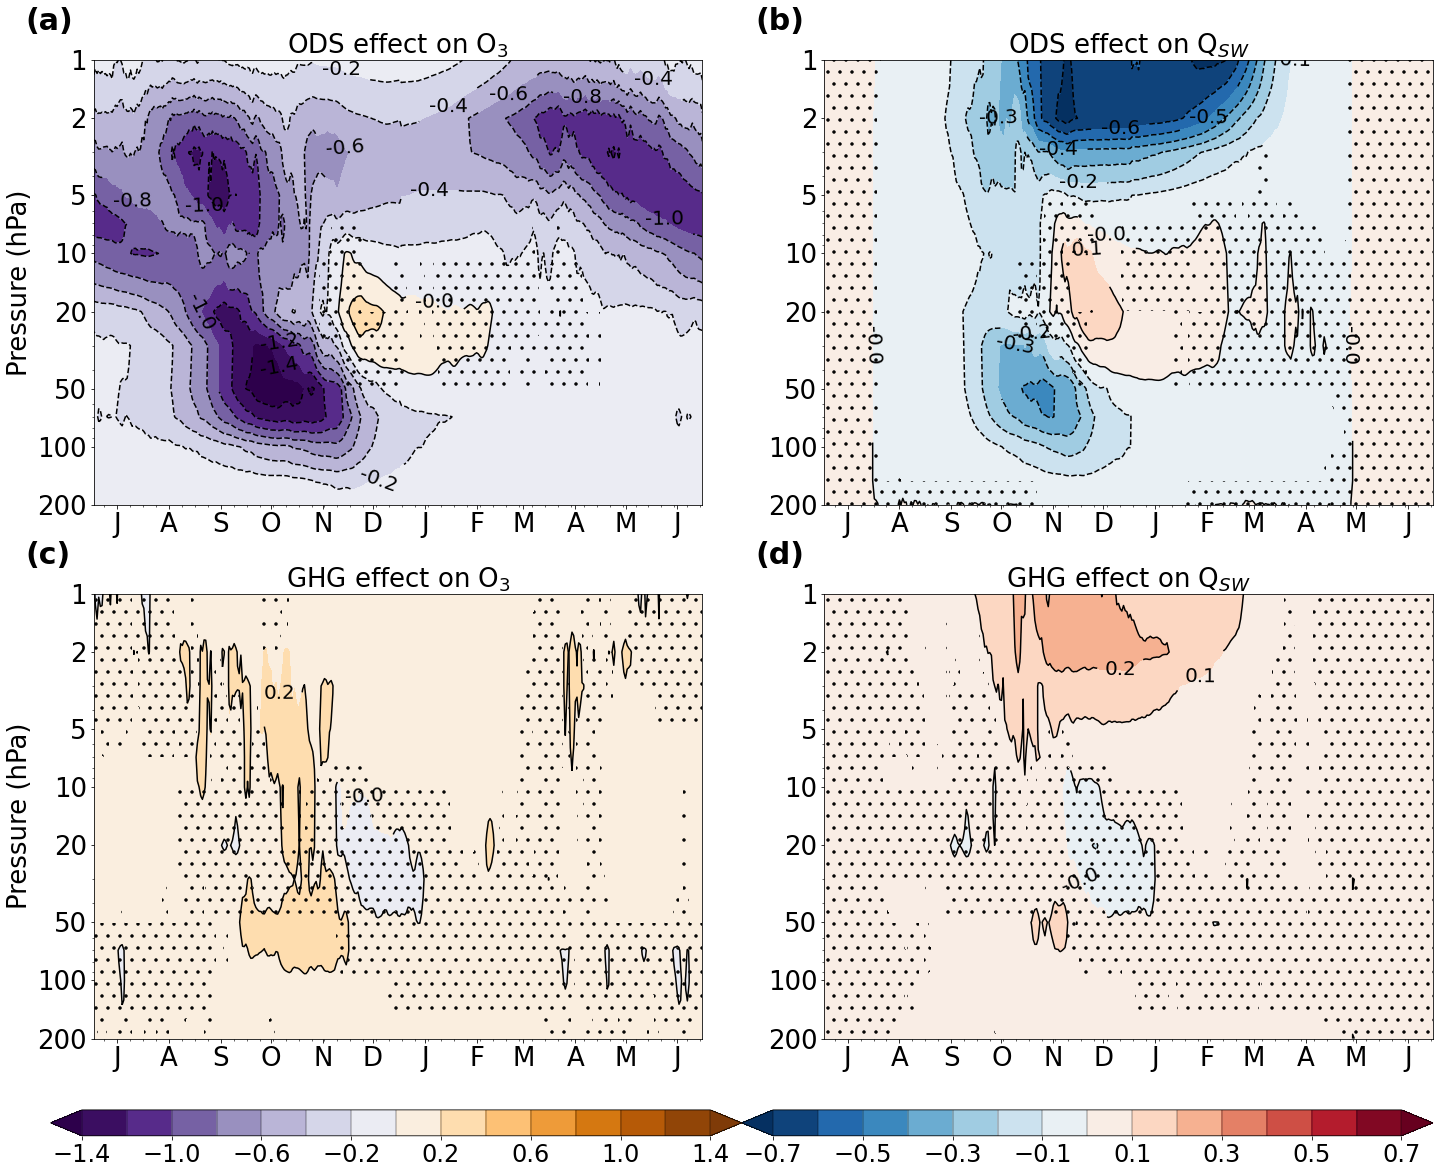

In [20]:
fig = plt.figure(figsize=(24,18))

cont = np.arange(-1.4,1.5, 0.2)
cont2 = np.arange(0,7,1)
con1 = mon_plev_O3(ods, ods_sign, ref_mean, cont, cont2, 'ODS effect on O$_3$', '(a)', 1)
con1 = mon_plev_O3(ghg, ghg_sign, ref_mean, cont, cont2, 'GHG effect on O$_3$', '(c)', 3)

cax = plt.axes([0.1, 0.05, 0.4, 0.02])
ticks = np.arange(-1.4,1.5, 0.4)
c = plt.colorbar(con1, ticks=ticks, cax=cax,  drawedges=True, orientation='horizontal')
c.ax.tick_params(labelsize=24)

cont = np.arange(-0.7,0.71, 0.1)
cont2 = np.arange(-14,14.1,1)
con2 = mon_plev_sw(ods_diff_sw, ods_diff_sign_sw, ref_mean_sw, cont, cont2, 'ODS effect on Q$_{SW}$', '(b)', 2)
con2 = mon_plev_sw(ghg_diff_sw, ghg_diff_sign_sw, ref_mean_sw, cont, cont2, 'GHG effect on Q$_{SW}$', '(d)', 4)

cax = plt.axes([0.5, 0.05, 0.4, 0.02])
ticks = np.arange(-0.7,0.71, 0.2)
c = plt.colorbar(con2, ticks=ticks, cax=cax,  drawedges=True, orientation='horizontal')
c.ax.tick_params(labelsize=24)